# Fitting Kepler-10 Data

In this workbook we'll go through the process of fitting Kepler data with linear models.

In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np

In [2]:
workbook_data = pickle.load(open("data/workbook_1.p", "rb"))
x, y, ye = workbook_data["x"], workbook_data["y"], workbook_data["ye"]
y, ye = y / y.mean(), ye / y.mean()
period, t0, duration = (
    workbook_data["period"],
    workbook_data["t0"],
    workbook_data["duration"],
)

[Text(0.5, 0, 'Time [BKJD]'),
 Text(0, 0.5, 'Flux [e-/s]'),
 Text(0.5, 1.0, 'Kepler-10')]

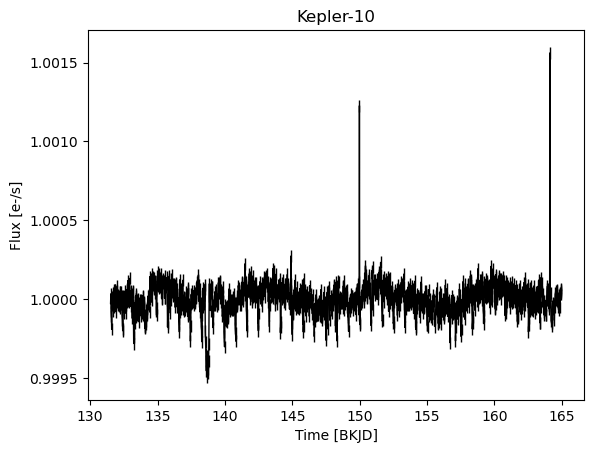

In [3]:
fig, ax = plt.subplots()
ax.errorbar(x, y, ye, color="k", lw=1)
ax.set(xlabel="Time [BKJD]", ylabel="Flux [e-/s]", title="Kepler-10")

## Step 1: Create a design matrix

Create a design matrix for the data above. The design matrix should consist of two "box" transit models (one for each planet) where the model is 0 outside of transit, and -1 during transit. The design matrix should have three vectors, including the first vector which is an offset term.

Overwrite `A` below to be your design matrix.

In [9]:
A0 = -np.asarray([((x - t0[idx]) % period[idx] < duration[idx]/2) for idx in range(2)], float).T
A1 = np.array([np.ones_like(x)]).T
A = np.hstack([A1, A0])

In [10]:
A

array([[ 1., -0., -0.],
       [ 1., -0., -0.],
       [ 1., -1., -0.],
       ...,
       [ 1., -0., -0.],
       [ 1., -0., -0.],
       [ 1., -0., -0.]])

In [11]:
assert np.isclose(A.dot([1, 0.1, 0.2]).sum(), 1614.5, atol=0.1)

## Step 2: Find the best fitting weights
Use the Weighted Least Squares equation to find the mean best fitting weights. 

Overwrite `w` below to be your mean best fitting weights. 

In [12]:
w = np.linalg.inv(A.T.dot(A)).dot(A.T).dot(y)

This is implicitly fitting the transit depth for the planets. Set the transit depth for each planet in `td_1` and `td_2` below.

In [13]:
td_1, td_2 = w[1], w[2]

In [14]:
assert np.isclose(td_1, 0.000143104, rtol=0.1)
assert np.isclose(td_2, 0.00044782345, rtol=0.1)

## Step 3: Improving the model

Assume that the stellar rotation period is `8.235401877719259` days. Create a model for the stellar variability and improve the fit for the transit depths.

Use 

- A sinusoid to capture the stellar variability
- Weighted Least Squares
- A mask to remove outliers

In [16]:
stellar_rotation_period = 8.235401877719259

In [18]:
A_star = np.vstack([np.ones_like(x), np.sin(2 * np.pi * x / stellar_rotation_period), np.cos(2 * np.pi * x / stellar_rotation_period)]).T
A = np.hstack([A_star, A0])

In [19]:
outliers = y > 1.0005

In [21]:
w = np.linalg.inv(A.T.dot(A)).dot(A.T).dot(y)

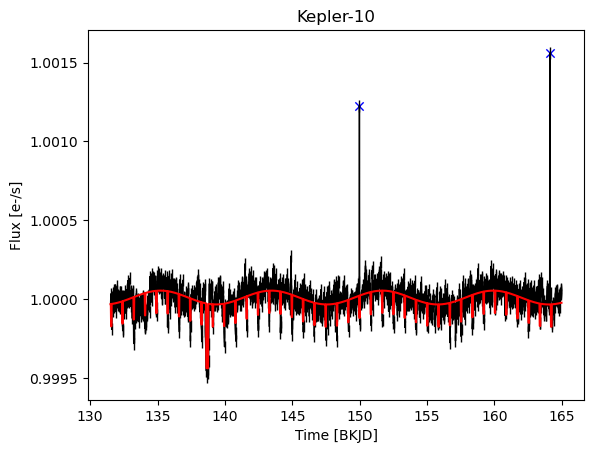

In [22]:
fig, ax = plt.subplots()
ax.errorbar(x, y, ye, color="k", lw=1, label="Data")
ax.scatter(x[outliers], y[outliers], color="b", lw=1, label="Data", marker='x')
ax.plot(x, A.dot(w), c="r", zorder=10, label="Model")
ax.set(xlabel="Time [BKJD]", ylabel="Flux [e-/s]", title="Kepler-10");

In [23]:
assert np.allclose(w[-2:], np.asarray([0.00015893, 0.00040655]), rtol=0.02)

AssertionError: 

In [24]:
w

array([ 1.00000945e+00,  2.14837906e-05, -3.82787233e-05,  1.41528823e-04,
        4.09560742e-04])